 ## 전이학습

 학습된걸 받아와서 거기서 추가로 학습시키겠다.
 위대하신 sklearn님처럼 클래스로 다 배포되어 있음. keras!

 .fit 하면 되지는 않는다. 조금 더 있음

 resNet을 쓸 때 기본 weight를 쓸수도 있지만 미리 학습된 weight 가져다가 쓸 수 있다.
 weight 학습할때 자원이 많이 필요해서 직접 하려고 하면 버거운 경우가 많다.
 그래서 미리 학습된 weight도 같이 배포해 주는것.

 weight
 - 초기값 상태
 - pre-trained -> 이거는 무슨 데이터로 학습된 데이터지?
     - imageNet 데이터.(ILSVRC 대회에서 쓰던 데이터)
     - 1000개 클래스. 강아지 품종, 자동차 종류, 비행기 종류 등등.
     - 이미지 사이즈 : 다양, 우리는 224*224 사용


In [ ]:
import tensorflow as tf


In [ ]:
dir(tf.keras.applications)


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50


In [ ]:
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt


In [ ]:
# 케라스 데이터셋을 다운받아 변수에 각각 넣어준다.
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape


In [ ]:
# 라벨 설정
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# 이미지 불러보기
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i][0]])
plt.show()


 ## Pretrained model 그대로 사용

In [ ]:
# include_top : head 같이 가져올거? 버리고 가져올거?
# input_shape : 정해줄 수 있음. 
model = ResNet50(include_top=True, input_shape = (224, 224 ,3), weights = 'imagenet')


 1) include_top = True, 분류기(완전연결계층) 여부
 2) weights = 'imagenet', 사전학습 weight 여부
 3) input_shape, Input 사이즈

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = 'accuracy')


In [ ]:
# test_images = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(test_images[:1000])
# test_images = tf.keras.applications.resnet50.preprocess_input(test_images)
resize = lambda x: tf.image.resize(x, (224, 224))
test_images = resize(test_images)
test_images.shape


In [ ]:
model.evaluate(test_images, test_labels) 


 ## 전이학습 (transfer learning)

 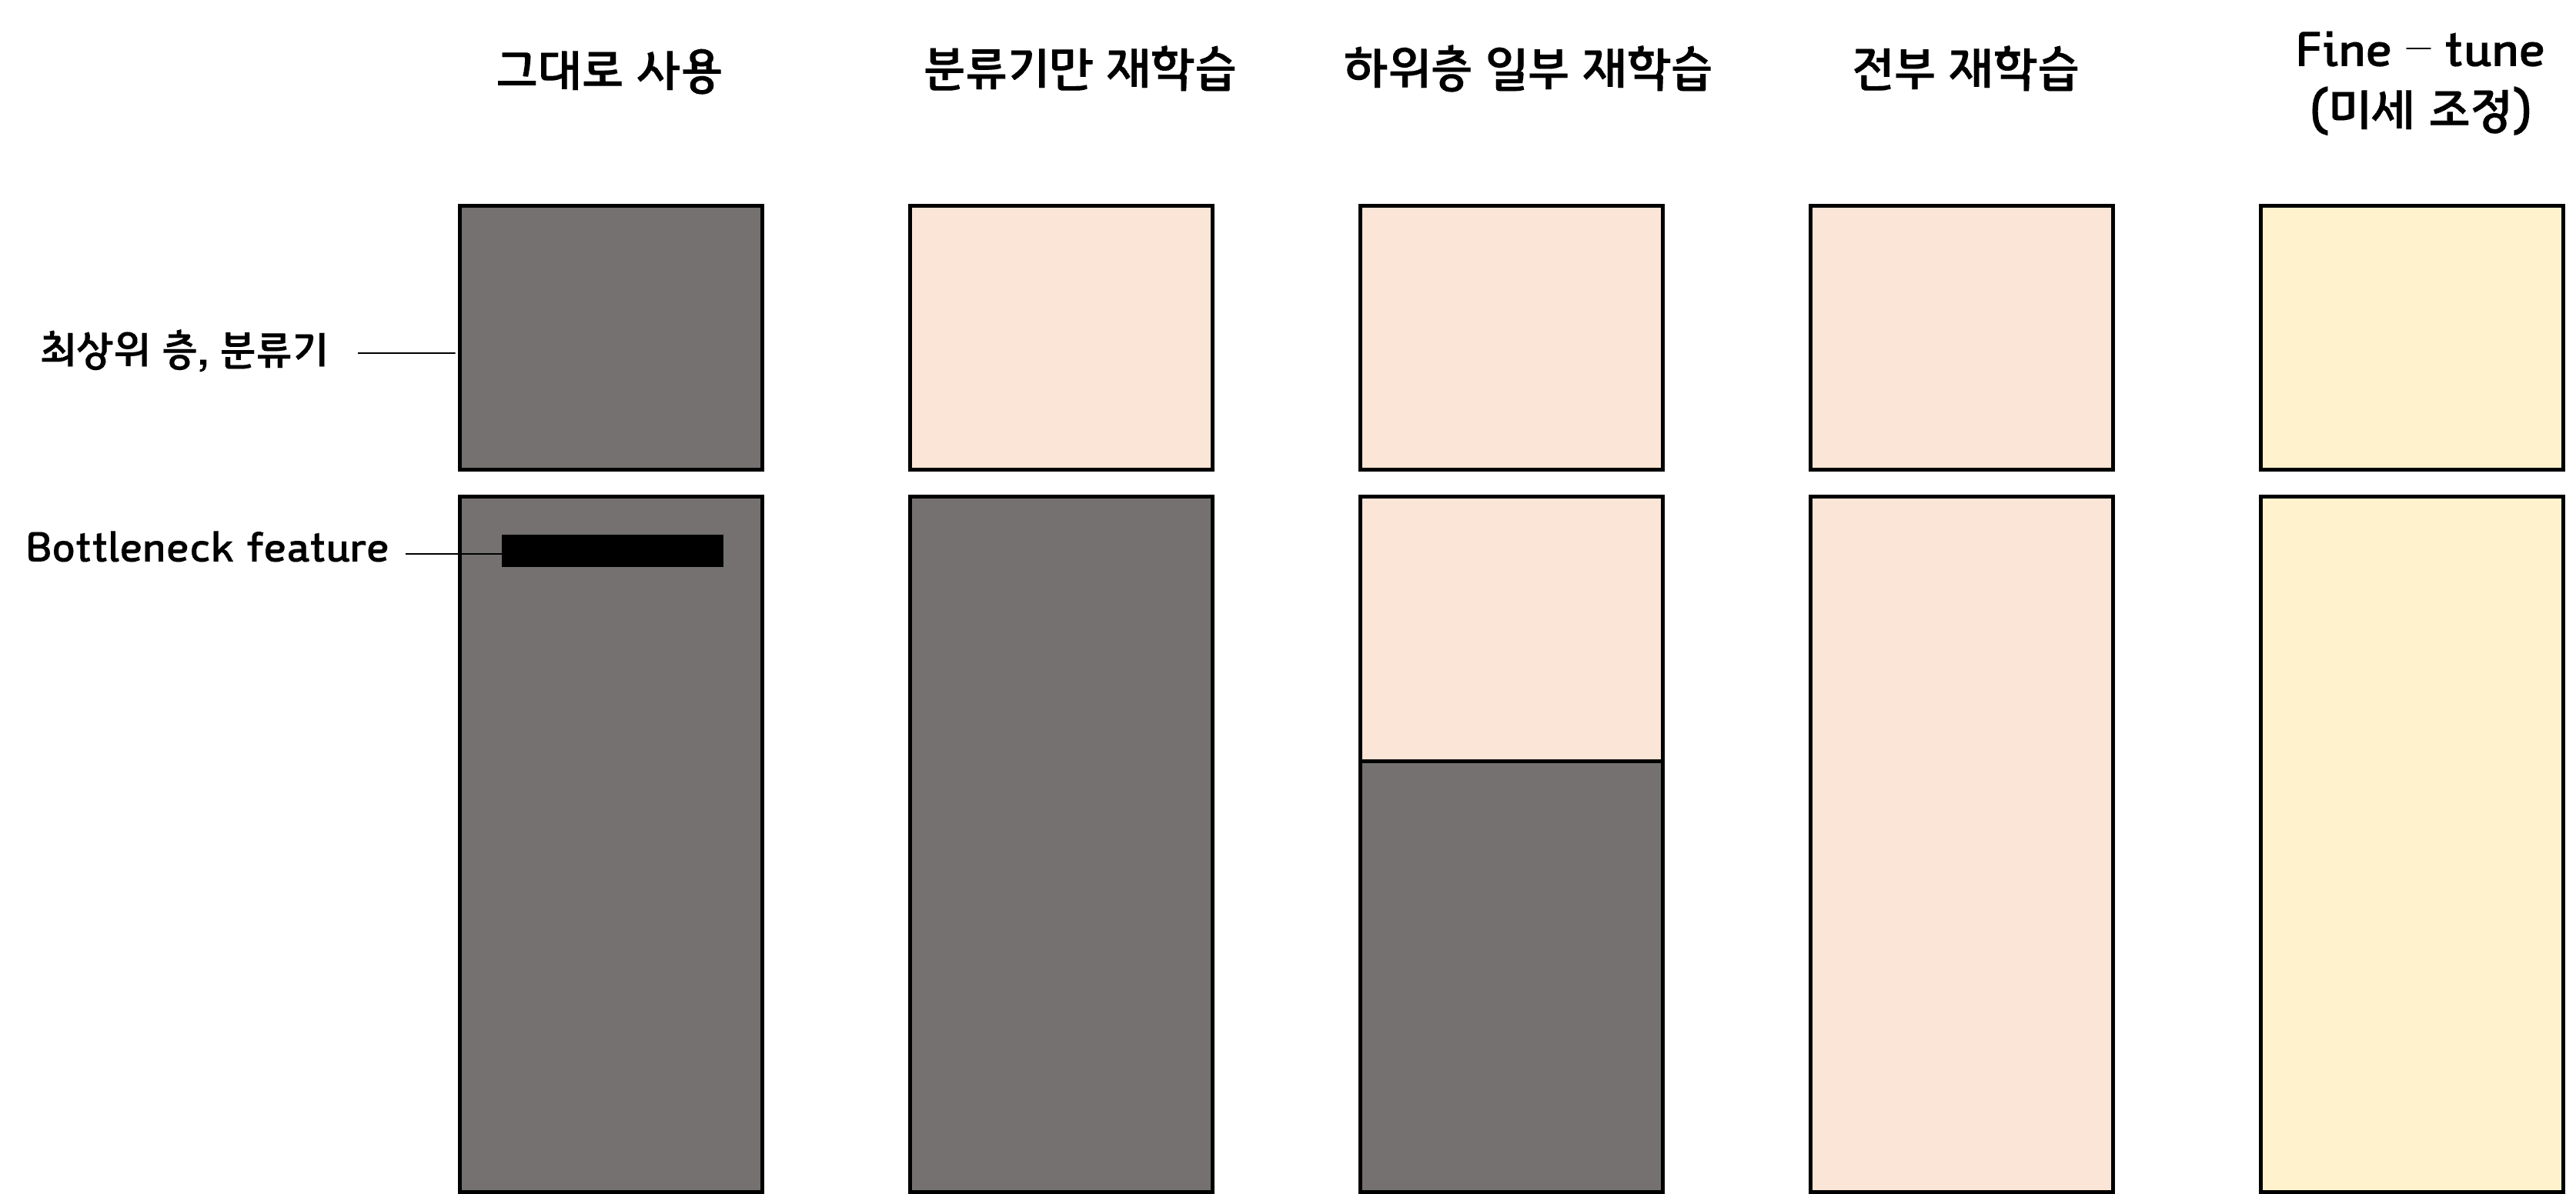

 ### 분류기부분만 재학습

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape


In [ ]:
# 우리는 include_top False로 줘야한다.
# 왜 include_top이 False면 input_shape을 바꿔도 될까? flatten 했을때 size때문에 못하는건데 top 없으면 상관없지!
# weights : 어떤 dataset으로 학습된 weight 가져올건지. 그럼 다른것도 있나?
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')


In [ ]:
base_model.output_shape
# 224, 224로 바꾸면 shape 7*7 된다.
# ==> pooling 5번 하나보다!


 1) include_top = True, 분류기(완전연결계층) 여부
 2) weights = 'imagenet', 사전학습 weight 여부
 3) input_shape, Input 사이즈 (32, 32, 3)으로 변경

In [ ]:
# backbone train하지 않겠다!
base_model.trainable = False


In [ ]:
# sparse categorical crossentropy VS categorical crossentropy + one_hot 
y_train = tf.keras.utils.to_categorical(train_labels, 10)
y_test = tf.keras.utils.to_categorical(test_labels, 10)
y_train.shape, y_test.shape


In [ ]:
y_train[0]


In [ ]:
# model.Sequential()없이 모델 구축하는 방법
# inputs : input images
inputs = tf.keras.Input(shape=(32, 32, 3))
# base_model : backbone. x = backbone 연산 끝난 마지막 데이터. 1*1*2048
# training : batchNormalization에 학습이 필요한 parameter가 있다. 이 parameter를 업데이트 하지 않겠다.
# 꼭 그래야하는건 아니지만 전이학습할때는 false가 기본이다.
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')
x = base_model.call(inputs, training=False)
# x를 flatten에 연결
##### 여기부터 custom head
x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
# flatten 한거랑 256이랑 fulley connected 계산
x = tf.keras.layers.Dense(256, activation='relu')(x)
# 0.5 비율로 드랍아웃 한다
x= tf.keras.layers.Dropout(0.5)(x)
# 분류
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


In [ ]:
type(x)


In [ ]:
tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]).call(x)


In [ ]:
model.summary()


In [ ]:
# categorical_crossentropy 원핫인코딩 되어있는 상태인가봄
# Adam class로 넣어줌
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 fitting
# batch_size 그냥 계산 쉬우라고 125로 준다.
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), batch_size=125)
# 성능 0.6184. imput image의 size도 다르고, backbone의 학습을 안시킨 상태라서 그렇슴.


 ### 하위층 일부 재학습

In [ ]:
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')


In [ ]:
# base_model.layers : list. 50층인데 왜 175???
len(base_model.layers)


In [ ]:
base_model.layers[:]
# zero padding, batch norm 등등 자잘한거 다 layer로 잡힘. 우리가 세던 레이어는 50개
# 레이어 1개에 conv, bn, relu 가 세진다. 그래서 대략 *3 + 알파.


In [ ]:
# 이렇게 하면 전체 base model이 train 하지 않는다.
base_model.trainable = False
base_model.trainable


In [ ]:
base_model.trainable =True
base_model.trainable


In [ ]:
# 그래서 전체 true 만들어주고 뒤에서 20개 남기고 나머지는 false로 바꾼다.
# => 175개중에 20개(backbone중 일부) 학습시킨다.
for layer in base_model.layers[:-20]: 
  layer.trainable = False				

for layer in base_model.layers[-100:]:	
  print(layer.name, layer.trainable)


In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()


In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)


 ### 전부 재학습

In [ ]:
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')


In [ ]:
base_model.trainable = True				

for layer in base_model.layers[:]:	
  print(layer.name, layer.trainable)


In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()


In [ ]:
model.trainable


In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)


 ### 미세조정 (fine tune)

In [ ]:
## 일부 재학습 모델
base_model = ResNet50(include_top=False, input_shape = (32,32 ,3), weights = 'imagenet')

# base_model.trainable = False

# for layer in base_model.layers[-10:]: 
#     layer.trainable = True				

base_model.trainable = True

for layer in base_model.layers[:-10]: 
    layer.trainable = False				
# head쪽 10개까지 학습시키기

inputs = tf.keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False) # batchnorm 부분 update 방지

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])


In [ ]:
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)


In [ ]:
## fine-tune
# head+10개 학습시키고 나서 전체 학습 다시 시킨다
base_model.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), 
                   batch_size= 125)


 - base model 불러오기(VGG16)
 - head 안가져온다
 - 이미지 shape : 32 * 32 * 3
 - 완전연결계층 1~3 자유롭게, 노드 갯수도 자유롭게

 ---

 1. head만 학습
 2. backbone 전체 개방해서 fine - tune 하기

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model = VGG19(include_top=False, input_shape = (32, 32 ,3), weights = 'imagenet')


In [ ]:
# dataset 다운받기
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# class name 설정
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# back bone 학습 안되게 막기
base_model.trainable = False
base_model.trainable


In [ ]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(train_labels, 10)
y_test = tf.keras.utils.to_categorical(test_labels, 10)


In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# categorical_crossentropy
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 fitting
model.fit(train_images, y_train, epochs = 5, validation_data=(test_images, y_test), batch_size=64)


In [ ]:
type(base_model)


 ## 과제

 dataset : 01_2_1의 캐글 데이터셋 사용.
 01_2_1_image_large_scale_preprocessing, 01_3_image_augmentation(flow_from_directory() 사용) 해서 데이터를 가공하고,
 해당 데이터로 input 받아서 전이학습.
 ResNet 사용, callback은 원하는거 사용.

 flow_from_directory은 사용 예제 코드 올려주실 것.